# Why do we not want kids?

Exploring the connection between education and kids: Does the length of womans education, effect the amount of kids, that she gets?

To explore the relationship, we use data from Statistikbanken, on fertility and education length. In the analysis, we compare our findings to other countries, using data from eurostat. 

Imports and set magics:

To run our code, you have to install the DST API wrapper and Pandas-datareader

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import ipywidgets as widgets
from IPython.display import display

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
# The DST API wrapper
%pip install git+https://github.com/alemartinello/dstapi

# A wrapper for multiple APIs with a pandas interface
%pip install pandas-datareader

# user written modules
import dataproject


  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/12/264rh1fs0qdgby4_yjl2rst40000gn/T/pip-req-build-pgjkr83e
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/12/264rh1fs0qdgby4_yjl2rst40000gn/T/pip-req-build-pgjkr83e
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import pandas as pd
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

import warnings
warnings.filterwarnings('ignore')

# Read and clean data

First, we install a CSV files from DST, that includes data regarding the education in denmark among the population.

In [3]:
#Load the data from Statistik Banken
ind = DstApi('HFUDD11')


Then we start cleaning the data

In [4]:
#Set the language to english
tabsum = ind.tablesummary(language='en')


# The _define_base_params -method gives us a nice template (selects all available data)
params = ind._define_base_params(language='en')
params


# Table of HFUD11 cleaned
from dataproject import HFUD11_data

processed_data = HFUD11_data()
processed_data.head(10)

Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00
Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


,municipality,year,BA
2,Aalborg,2008,3497
5,Aalborg,2009,3646
8,Aalborg,2010,4001
11,Aalborg,2011,4293
14,Aalborg,2012,4414
17,Aalborg,2013,4661
20,Aalborg,2014,5165
23,Aalborg,2015,5490
26,Aalborg,2016,5842
29,Aalborg,2017,5932


The table above shows, how many people across all ages and etnicities in Denmark, that have at least a Bachelor degree, in Aalborg, Thisted and Copenhagen and years. 

Then we download data about the fertility in Denmark based on area and age

In [5]:
# Table of FOD407 cleaned
from dataproject import FOD407_data

processed_data = FOD407_data()
processed_data.head(10)

Table FOD407: Fertility rates by region, age and time
Last update: 2024-02-12T08:00:00


,municipality,year,fertilitykvotient
41,Aalborg,2006,1681.4
44,Aalborg,2007,1686.6
47,Aalborg,2008,1765.2
50,Aalborg,2009,1724.8
35,Aalborg,2010,1743.1
53,Aalborg,2011,1610.9
38,Aalborg,2012,1624.0
15,Aalborg,2013,1546.2
12,Aalborg,2014,1542.4
5,Aalborg,2015,1639.5


The tables shows the fertility i Aalborg, Copenhagen and Thisted across years in Denmark for women in all ages. 

## Explore each data set

**Interactive plot** :

To explore our data sets, we make an interactive figure. The figure shows, the fertility rate and how many people have a BA in the three regions, that we have chosen. 

In [7]:
from dataproject import FOD407_data
from dataproject import HFUD11_data
# First we call our two cleaned tables
fert_api = FOD407_data()
ind_api = HFUD11_data()

Table FOD407: Fertility rates by region, age and time
Last update: 2024-02-12T08:00:00
Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


In [8]:

#First we define the function, that we are plotting
def plot_e(df, municipality): 
    #The boolean series returns true for rows, where the value in the municipality coloumn mtches the municipality parameter.
    I = df['municipality'] == municipality
    #df.loc[I:] filters the dataframe using the boolean series to include only those rowsa where the municipality matches.
    #year is set on the x-axis, BA is set as the y-axis,
    ax=df.loc[I,:].plot(x='year', y='BA', style='-o', legend=False)

#Secondly, we make the widget interaction.
widgets.interact(plot_e, 
    #ind_api is fixed
    df = widgets.fixed(ind_api),
    #creates a dropdoen widget for selecting municipality. The default value is selected as Copenhagen. 
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=ind_api.municipality.unique(), 
                                    value='Copenhagen')
); 


interactive(children=(Dropdown(description='Municipality', index=1, options=('Aalborg', 'Copenhagen', 'Thisted…

When changing the municipality we can see, that the amount of people with a Bachelor degree, has been increasing for all 3 cities since 2008. Copenhagen has the highest total amont of people with a bachelor degree, however Thisted has seen the largest increase for the past years. 

# Merge data sets

Before we merge the data sets, we check; that the years are the same in the datasets, and the dataset has information about the same municipalities. 

In [14]:
#We determine, if there is a difference in the years and municipalities in the two datasets, that we are using. 

#First for years
diff_y = [y for y in fert_api.year.unique() if y not in ind_api.year.unique()] 
print(f'years in fertility data, but not in education data: {diff_y}')


#Then for municipalities
diff_m = [m for m in fert_api.municipality.unique() if m not in ind_api.municipality.unique()] 
print(f'muncipalities in fertility data, but not in education data: {diff_m}')



years in fertility data, but not in education data: [2006, 2007]
muncipalities in fertility data, but not in education data: []
muncipalities in fertility data, but not in education data: []


From the above we can see, that the dataset regarding fertility contains data from the years 2006, 2007 and 2023, that is not contained in the dataset about education.

Otherwise, the two datasets contains information about fertility and municiaplities in the same years. 

We are now going to merge the two datasets using the left merge method, so we don't get the years 2006, 2007 and 2008. 

In [19]:
from dataproject import FOD407_data
from dataproject import HFUD11_data

# We first call the two functions, that we want to merge.
fert_api = FOD407_data()
ind_api = HFUD11_data()


#We then use the left merge method

#First, we merge the two datesets on municipality using a left merge. 
#All rows from ind_api will be included, and the matching rowsa from fert_api will be added. 
inner_with_area = pd.merge(ind_api, fert_api, on='municipality', how='left')

#This deletes the columns named year_y, so we only have 1 coloumn describing the years. 
del inner_with_area['year_y']

#Renamig coloumn
inner_with_area = inner_with_area.rename(columns={"year_x":"year"})


#Converting values to numeric types
inner_with_area['fertilitykvotient'] = pd.to_numeric(inner_with_area['fertilitykvotient'], errors='coerce')


#Displaying the dataframe
inner_with_area.head(10)


Table FOD407: Fertility rates by region, age and time
Last update: 2024-02-12T08:00:00
Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


,municipality,year,BA,fertilitykvotient
0,Aalborg,2008,3497,1681.4
1,Aalborg,2008,3497,1686.6
2,Aalborg,2008,3497,1765.2
3,Aalborg,2008,3497,1724.8
4,Aalborg,2008,3497,1743.1
5,Aalborg,2008,3497,1610.9
6,Aalborg,2008,3497,1624.0
7,Aalborg,2008,3497,1546.2
8,Aalborg,2008,3497,1542.4
9,Aalborg,2008,3497,1639.5


The table above shows, how many people have a BA degree and the fertility kvotient in Aalborg, Thisted and Copenhagen.

# Analysis

To find a relationship between the fertility and amount of people with a higher education, we plot the development in fertility and education in the same coordinatsystem. 

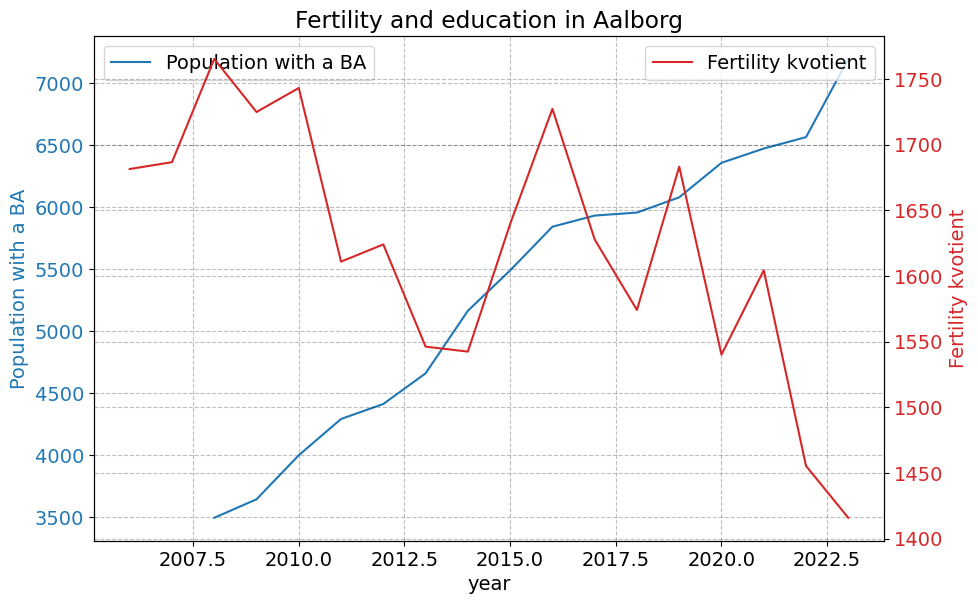

In [20]:
from dataproject import plot_fer_BA_copenhagen

# Call the function to plot
plot_fer_BA_copenhagen(ind_api, fert_api)

From the table above, we can see, that the number of people with a BA has increased. Opposite the fertilitykvotient has decreased. 

From 2006-2020 the fertility seemed rather constant. However, it fell drastically in 2020. In the same period, the amount of people with a BA increased significantly compared to prior years. 

This could indicate, that when people take a longer education, they get fewer kids. 

We want to determine, if the same relationsship is evident in Thisted and Aalborg. 

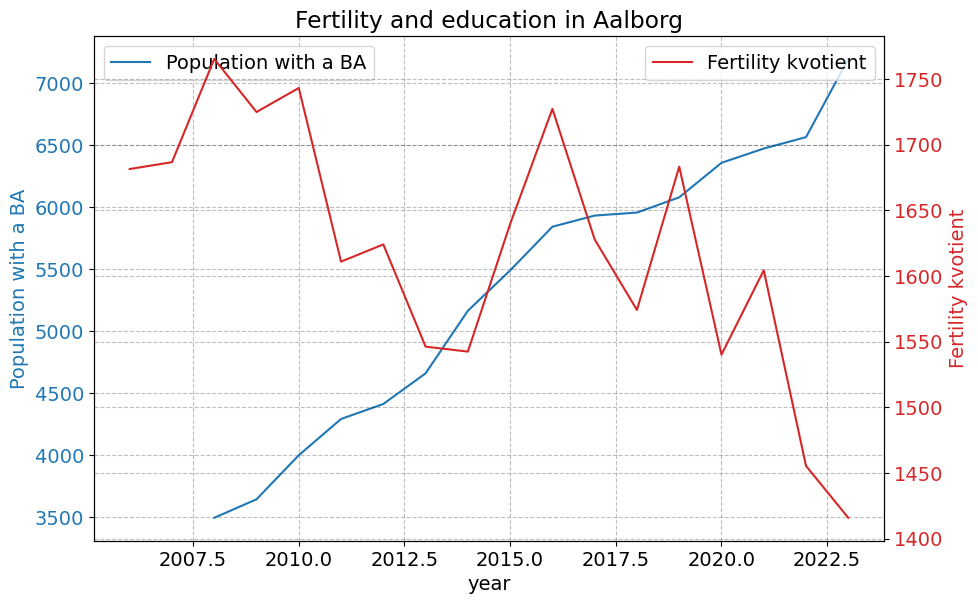

In [21]:
#Plot for Aalborg

from dataproject import plot_fer_BA_aalborg

# Call the function to plot
plot_fer_BA_aalborg(ind_api, fert_api)

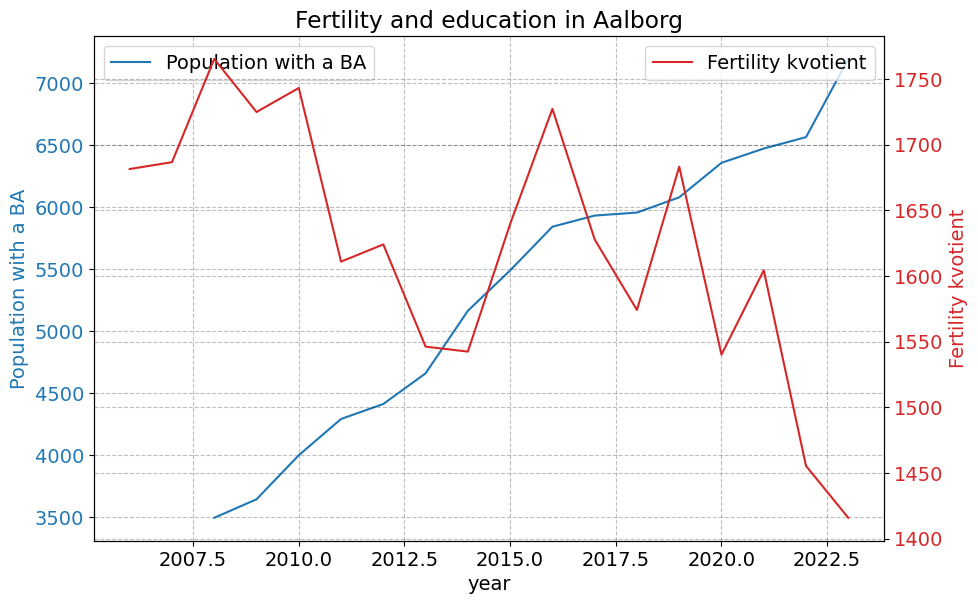

In [22]:
#Plot for Thisted

from dataproject import plot_fer_BA_aalborg

# Call the function to plot
plot_fer_BA_copenhagen(ind_api, fert_api)

The data from Thisted and Aalborg shows the same as Copenhagen. For the last years, people have been taking longer education, which might have led to a decrease in the fertilitykvotient. Especially in the last few years, the amount of people with a bachelor education has increased significantly and the fertilitykvotient has decreased a lot. 

We now want to analyze, if the observations above, is also evident in other countries:

# Conclusion

From our analysis we can conclude, that there might be a negative relationship between taking a longer education and the fertility. 